# Regression

#### Import des données et paramétrage

In [1]:
#imports
library(readr)
library(e1071)
library(caret)
library(MLmetrics)

# Lecture des données
data <- read_csv("Data/DataEnergy.csv")

Warning message:
"package 'e1071' was built under R version 4.0.3"
Warning message:
"package 'caret' was built under R version 4.0.3"
Loading required package: lattice

Loading required package: ggplot2

Warning message:
"package 'MLmetrics' was built under R version 4.0.3"

Attaching package: 'MLmetrics'


The following objects are masked from 'package:caret':

    MAE, RMSE


The following object is masked from 'package:base':

    Recall


Parsed with column specification:
cols(
  Relative.compactness = col_double(),
  Surface.area = col_double(),
  Wall.area = col_double(),
  Roof.area = col_double(),
  Overall.height = col_double(),
  orientation = col_character(),
  Glazing.area = col_double(),
  Glazing.area.distr = col_double(),
  Energy = col_double(),
  Energy.efficiency = col_character()
)



In [2]:
#Utilities 
#Fonction de seuillage :
to_class<-function(x){
    if (x<30){
        return("A")
    } else if(x<35){
        return("B")
    } else if(x<45){
        return("C")
    } else if(x<55){
        return("D")
    } else if(x<65){
        return("E")
    } else if(x<75){
        return("F")
    }else{
        return("G")
    }
}

to_class_list<-function(l){
    result = l
    lapply(result, to_class)
}

#### Séparation du jeu de données en training/test

In [3]:
n <- nrow(data)
learnSet <- sample(1:n, size = floor(n * 4 / 5))
testSet <- setdiff(1:n, learnSet)

build <- data[, - 4]  # remove Roof.area
buildR <- build[, - c(9)] # for regression, keep Energy as output
buildC <- build[, - c(8)] # for classification, keep Energy.efficiency

buildRlearn <- buildR[learnSet, ]
buildRtest <- buildR[testSet, ]
buildClearn <- buildC[learnSet, ]
buildCtest <- buildC[testSet, ]

## Modèle linéaire

 le paramètre à varier pour la selection du meilleur modèle est le critère AIC.
 
 

In [4]:
library(MASS)

In [5]:
Reg=lm( Energy ~ ., data = buildRlearn)
# Selection du meilleur modèle automatique

stepAIC(Reg)
RegMeilleur=lm(Energy~Relative.compactness+Surface.area+Wall.area+
                  Overall.height+Glazing.area,data=buildRlearn)
summary(RegMeilleur)

#prediction 
pre <- predict(RegMeilleur,newdata=buildRtest) 
erreurs <- (t((buildRtest[, 8])) - pre)
print("MSE = ")
print(mean(erreurs^2))

Start:  AIC=2358.69
Energy ~ Relative.compactness + Surface.area + Wall.area + Overall.height + 
    orientation + Glazing.area + Glazing.area.distr

                       Df Sum of Sq   RSS    AIC
- orientation           3     104.4 27797 2355.0
- Glazing.area.distr    1       6.2 27699 2356.8
<none>                              27693 2358.7
- Surface.area          1     249.3 27942 2362.2
- Relative.compactness  1     660.1 28353 2371.2
- Wall.area             1    1251.4 28944 2383.8
- Overall.height        1    7389.2 35082 2501.9
- Glazing.area          1   13642.6 41336 2602.6

Step:  AIC=2355
Energy ~ Relative.compactness + Surface.area + Wall.area + Overall.height + 
    Glazing.area + Glazing.area.distr

                       Df Sum of Sq   RSS    AIC
- Glazing.area.distr    1       6.7 27804 2353.2
<none>                              27797 2355.0
- Surface.area          1     254.5 28052 2358.6
- Relative.compactness  1     668.4 28466 2367.6
- Wall.area             1    12


Call:
lm(formula = Energy ~ Relative.compactness + Surface.area + Wall.area + 
    Overall.height + Glazing.area, data = buildRlearn)

Coefficients:
         (Intercept)  Relative.compactness          Surface.area  
            72.05149             -75.97731              -0.07896  
           Wall.area        Overall.height          Glazing.area  
             0.08261               9.78406              36.19168  



Call:
lm(formula = Energy ~ Relative.compactness + Surface.area + Wall.area + 
    Overall.height + Glazing.area, data = buildRlearn)

Residuals:
     Min       1Q   Median       3Q      Max 
-21.3538  -4.3464  -0.1212   4.2406  21.2656 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           72.05149   36.48374   1.975 0.048732 *  
Relative.compactness -75.97731   19.79612  -3.838 0.000137 ***
Surface.area          -0.07896    0.03328  -2.373 0.017967 *  
Wall.area              0.08261    0.01572   5.255 2.05e-07 ***
Overall.height         9.78406    0.77034  12.701  < 2e-16 ***
Glazing.area          36.19168    2.03075  17.822  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.762 on 608 degrees of freedom
Multiple R-squared:  0.8848,	Adjusted R-squared:  0.8838 
F-statistic: 933.6 on 5 and 608 DF,  p-value: < 2.2e-16


[1] "MSE = "
[1] 62.64839


#### Meilleur modèle de régression linéaire

In [6]:
conf <- table(data = as.data.frame(to_class_list(pre)), 
                            reference = buildCtest$Energy.efficiency)

print("F1 Score : ")
F1_Score(y_pred = as.data.frame(to_class_list(pre)), y_true = buildCtest$Energy.efficiency)
print("Accuracy : ")
Accuracy(y_pred = as.data.frame(to_class_list(pre)), y_true = buildCtest$Energy.efficiency)

[1] "F1 Score : "


[1] 0.7906977

[1] "Accuracy : "


[1] 0.4935065

## Support Vector Regression

#### Essai avec les parametres par défaut

In [7]:
SVMR <- svm(Energy ~ ., data = buildRlearn)
SVMR.pred <- predict(SVMR, buildRtest[, - 8])
erreurs <- (t(buildRtest[, 8]) - SVMR.pred)
print("MSE = ")
print(mean(erreurs^2))

[1] "MSE = "
[1] 50.61141


#### Tuning des hyperparametres

In [8]:
tuneResult <- tune(svm, Energy~ ., 
                    data = buildRlearn,
                    ranges = list(epsilon = seq(0,1,0.2), cost = 2^(2:9), kernel = list("linear", "polynomial", "radial", "sigmoid")),
                    tunecontrol = tune.control(nrepeat = 5, sampling = "cross", cross = 3))
print(tuneResult)


Parameter tuning of 'svm':

- sampling method: 3-fold cross validation 

- best parameters:
 epsilon cost     kernel
     0.2  128 polynomial

- best performance: 41.17209 



In [9]:
tuned.model <- tuneResult$best.model
tuned.pred <- predict(tuned.model, buildRtest[, - 8])
erreurs <- (t(buildRtest[, 8]) - tuned.pred)
print("MSE = ")
print(mean(erreurs^2))

[1] "MSE = "
[1] 46.77665


#### Observation des résultats de notre modèle de regression sur le problème de classification:

In [10]:
conf_svm <- table(data = as.data.frame(to_class_list(tuned.pred)), 
                            reference = buildCtest$Energy.efficiency)

print("F1 Score : ")
F1_Score(y_pred = as.data.frame(to_class_list(tuned.pred)), y_true = buildCtest$Energy.efficiency)
print("Accuracy : ")
Accuracy(y_pred = as.data.frame(to_class_list(tuned.pred)), y_true = buildCtest$Energy.efficiency)

[1] "F1 Score : "


[1] 0.7804878

[1] "Accuracy : "


[1] 0.5194805

## Random Forest

In [18]:
library(randomForest)
library("png")

Warning message:
"package 'png' was built under R version 4.0.3"


In [19]:
rf.reg=randomForest(Energy ~ Relative.compactness+Surface.area+Wall.area+
                   Overall.height+orientation+Glazing.area+  Glazing.area.distr, data = buildRlearn,
   ntree=300,do.trace=50,importance=TRUE)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
  50 |    21.04     5.35 |
 100 |    20.84     5.30 |
 150 |    20.98     5.34 |
 200 |    21.16     5.39 |
 250 |    21.07     5.36 |
 300 |    20.95     5.33 |


In [20]:
print(rf.reg) 


Call:
 randomForest(formula = Energy ~ Relative.compactness + Surface.area +      Wall.area + Overall.height + orientation + Glazing.area +      Glazing.area.distr, data = buildRlearn, ntree = 300, do.trace = 50,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 2

          Mean of squared residuals: 20.9465
                    % Var explained: 94.67


Evolution de la loss selon le nombre d'arbre

png 
  2

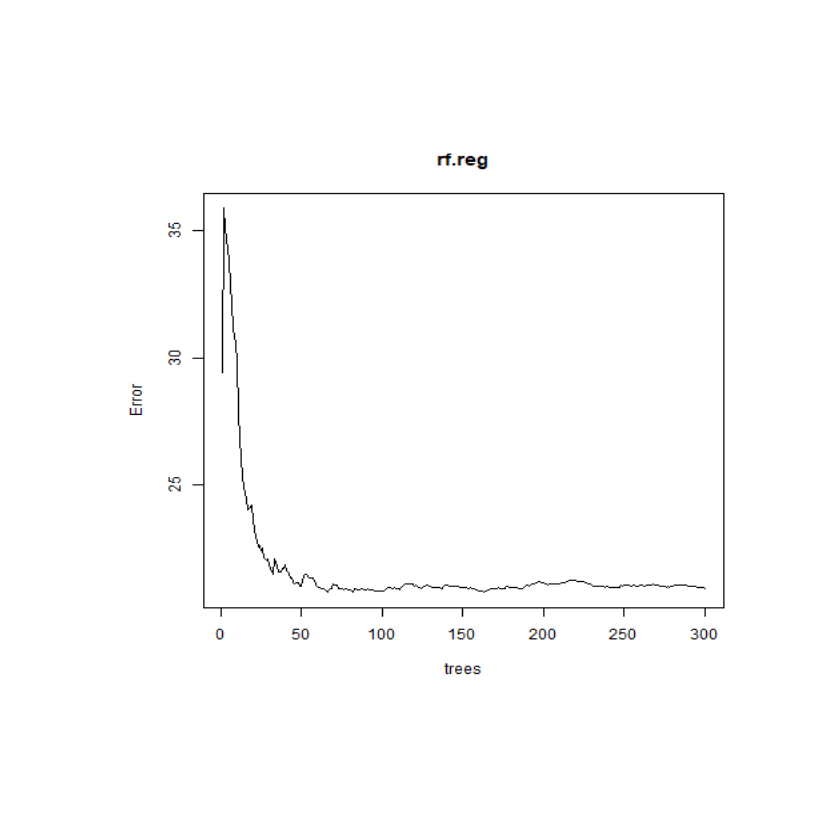

In [21]:
png(file = "randomForestRegression.png")   
# Plot the error vs the number of trees graph 
plot(rf.reg)  
# Saving the file 
dev.off() 

pp <- readPNG("randomForestRegression.png")
plot.new() 
rasterImage(pp,0,0,1,1)

In [22]:
#Prediction et performance du Random Forest
pred_rf <- predict(rf.reg,newdata=buildRtest)
res <- to_class_list(pred_rf)

In [24]:
conf_rf <- table(data = as.data.frame(res), reference = buildCtest$Energy.efficiency)
conf_rf

    reference
data  A  B  C  D  E  F  G
   A 35  7  1  0  0  0  0
   B  8  8  7  0  0  0  0
   C  0  1  8  0  0  0  0
   D  0  0  3  9  1  0  0
   E  0  0  0  9 16  9  0
   F  0  0  0  0  5 10  5
   G  0  0  0  0  0  2 10

In [26]:
# F1_score
print("F1 Score : ")
F1_Score(y_pred = as.data.frame(res), y_true = buildCtest$Energy.efficiency)
#Accuracy
print("Accuracy : ")
Accuracy(y_pred = as.data.frame(res), y_true = buildCtest$Energy.efficiency)

[1] "F1 Score : "


[1] 0.8139535

[1] "Accuracy : "


[1] 0.6233766

Le modèle rencontre des difficultés a prédire la classe B, nous allons maintenant essayer de l'optimiser en mettant a jour les paramètres.

### Optimisation du random forest

In [27]:
# Define the control of the cross validation
trControl <- trainControl(method = "cv",
    number = 3,
    search = "grid")

Nous allons d'abord essayer de trouver le meilleur mtry : nombre de variables testées à chaque split.

In [29]:
# search best_mtry
set.seed(1234)
tuneGrid <- expand.grid(.mtry = c(1: 8))
rf_mtry <- train(Energy ~Relative.compactness+Surface.area+Wall.area+
                     Overall.height+orientation+Glazing.area+  Glazing.area.distr,
    data = buildRlearn,
    method = "rf",
    metric = "RMSE",
    tuneGrid = tuneGrid,
    trControl = trControl,
    importance = TRUE,
    nodesize = 14,
    ntree = 500)
print(rf_mtry)

Random Forest 

614 samples
  7 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 409, 409, 410 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
  1     7.544144  0.9010245  5.990728
  2     5.138553  0.9353488  4.001541
  3     4.796408  0.9423778  3.732727
  4     4.722915  0.9438719  3.682303
  5     4.674291  0.9448191  3.666008
  6     4.663943  0.9449322  3.669267
  7     4.679384  0.9445306  3.679984
  8     4.663357  0.9448749  3.680440

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 8.


In [30]:
best_mtry = rf_mtry$bestTune$mtry
best_mtry

[1] 8

On cherche maintenant le meilleur max_node -> nombre de feuilles maximales dans chaque arbre de la forêt aléatoire.

In [32]:
store_maxnode <- list()
tuneGrid <- expand.grid(.mtry = best_mtry)
for (maxnodes in c(8: 30)) {
    set.seed(1234)
    rf_maxnode <- train(Energy ~Relative.compactness+Surface.area+Wall.area+
                     Overall.height+orientation+Glazing.area+  Glazing.area.distr,
        data = buildRlearn,
        method = "rf",
        metric = "RMSE",
        tuneGrid = tuneGrid,
        trControl = trControl,
        importance = TRUE,
        nodesize = 14,
        maxnodes = maxnodes,
        ntree = 500)
    current_iteration <- toString(maxnodes)
    store_maxnode[[current_iteration]] <- rf_maxnode
}
results_mtry <- resamples(store_maxnode)
summary(results_mtry)


Call:
summary.resamples(object = results_mtry)

Models: 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30 
Number of resamples: 3 

MAE 
       Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
8  4.162555 4.219285 4.276015 4.424312 4.555190 4.834364    0
9  4.092196 4.170530 4.248863 4.371980 4.511872 4.774882    0
10 4.026195 4.119323 4.212451 4.307840 4.448662 4.684873    0
11 3.967962 4.073413 4.178863 4.269078 4.419636 4.660408    0
12 3.918073 4.010495 4.102918 4.203205 4.345771 4.588624    0
13 3.943120 3.949359 3.955597 4.119814 4.208161 4.460725    0
14 3.879244 3.900727 3.922211 4.034822 4.112611 4.303012    0
15 3.792116 3.850464 3.908813 3.972815 4.063165 4.217517    0
16 3.811885 3.860814 3.909743 3.976873 4.059367 4.208990    0
17 3.785294 3.844362 3.903430 3.967590 4.058738 4.214046    0
18 3.780559 3.833433 3.886307 3.951049 4.036294 4.186281    0
19 3.772877 3.823448 3.874019 3.938542 4.021375 4.168731    0
20 3.784475 3.808

Pour le max_nodes on prend la valeur 28 minimum de la moyenne de RMSE

In [33]:
best_maxnodes = 28

Nous allons maintenant optimiser l'hyperparamètre maxtree qui est le nombre d'arbre dans la forêt aléatoire.

In [34]:
store_maxtrees <- list()
for (ntree in c(100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 800, 1000, 2000)) {
    set.seed(5678)
    rf_maxtrees <- train(Energy ~Relative.compactness+Surface.area+Wall.area+
                     Overall.height+orientation+Glazing.area+  Glazing.area.distr,
        data = buildRlearn,
        method = "rf",
        metric = "RMSE",
        tuneGrid = tuneGrid,
        trControl = trControl,
        importance = TRUE,
        nodesize = 14,
        maxnodes = 28,
        ntree = ntree)
    key <- toString(ntree)
    store_maxtrees[[key]] <- rf_maxtrees
}
results_tree <- resamples(store_maxtrees)
summary(results_tree)


Call:
summary.resamples(object = results_tree)

Models: 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 800, 1000, 2000 
Number of resamples: 3 

MAE 
         Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
100  3.370385 3.600305 3.830224 3.816421 4.039440 4.248655    0
200  3.368025 3.595150 3.822275 3.821374 4.048048 4.273822    0
250  3.370538 3.606923 3.843308 3.826793 4.054920 4.266531    0
300  3.369807 3.608829 3.847851 3.826305 4.054554 4.261256    0
350  3.374421 3.610285 3.846150 3.831343 4.059805 4.273459    0
400  3.367267 3.607492 3.847718 3.830509 4.062130 4.276543    0
450  3.365113 3.607470 3.849827 3.828064 4.059539 4.269251    0
500  3.363348 3.606806 3.850265 3.827294 4.059267 4.268269    0
550  3.362440 3.606084 3.849727 3.825418 4.056907 4.264087    0
600  3.361492 3.608409 3.855327 3.826734 4.059355 4.263384    0
800  3.356894 3.603405 3.849916 3.825282 4.059476 4.269035    0
1000 3.357303 3.603847 3.850392 3.825970 4.060304 4.270216    0
2000 3.353586 

on va prendre 200 arbre

In [36]:
fit_rf <- train(Energy~Relative.compactness+Surface.area+Wall.area+
                     Overall.height+orientation+Glazing.area+  Glazing.area.distr,
    buildRlearn,
    method = "rf",
    metric = "RMSE",
    tuneGrid = tuneGrid,
    trControl = trControl,
    importance = TRUE,
    ntree = 200,
    maxnodes = best_maxnodes)

In [39]:
predictions_rf <-to_class_list(predict(fit_rf, buildRtest))

In [41]:
conf_rf <- table(data = as.data.frame(predictions_rf), reference = buildCtest$Energy.efficiency)
conf_rf

    reference
data  A  B  C  D  E  F  G
   A 33  2  1  0  0  0  0
   B 10 13  8  0  0  0  0
   C  0  1  7  1  0  0  0
   D  0  0  3  6  4  0  0
   E  0  0  0 11 13  7  0
   F  0  0  0  0  4 13  9
   G  0  0  0  0  1  1  6

In [42]:
F1_Score(y_pred = as.data.frame(predictions_rf), y_true = buildCtest$Energy.efficiency)

[1] 0.835443

En mettant a jour nos parametre, on constate une legere hausse du score de notre modele.

## Gradient Boosting

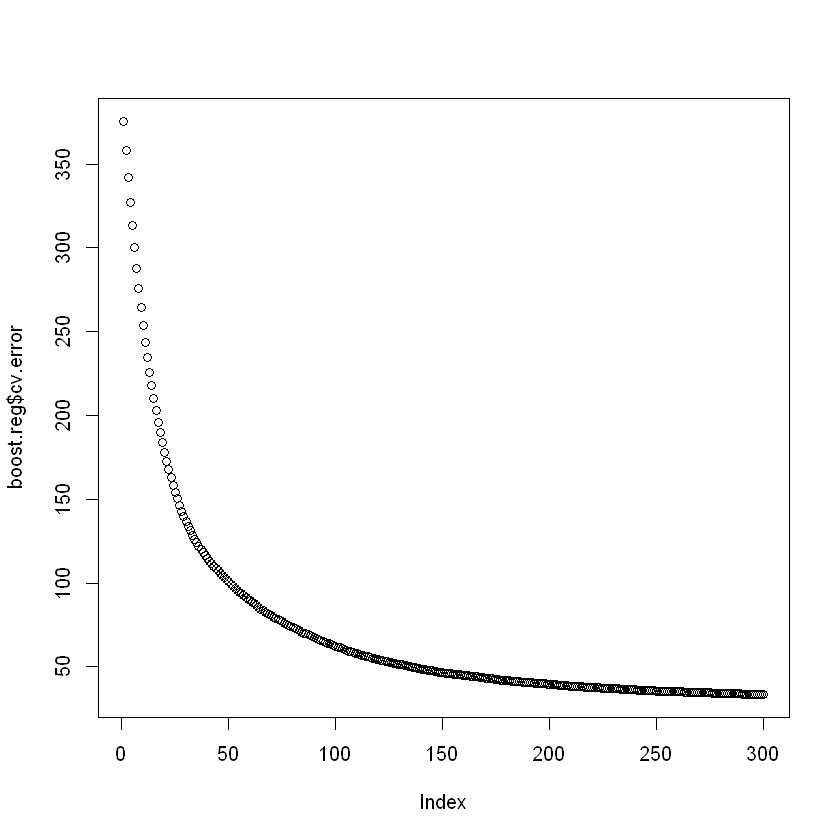

In [46]:
library(gbm)

boost.reg=gbm(Energy ~ Relative.compactness+Surface.area+Wall.area+
              Overall.height+Glazing.area+  Glazing.area.distr, data = buildRlearn,,distribution="gaussian"
              ,n.trees=300, cv.folds=10,n.minobsinnode = 5,shrinkage=0.03,verbose=FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error)

In [48]:
#Prediction et performance du Random Forest
pred_gb <- predict(boost.reg,newdata=buildRtest)
res_gb <- to_class_list(pred_gb)

Using 300 trees...




In [50]:
conf_rf <- table(data = as.data.frame(res_gb), reference = buildCtest$Energy.efficiency)
conf_rf

    reference
data  A  B  C  D  E  F  G
   A 33  2  1  0  0  0  0
   B 10 10  4  0  0  0  0
   C  0  3  9  0  0  0  0
   D  0  1  2  1  0  0  0
   E  0  0  3 16 17  9  0
   F  0  0  0  1  5 11  9
   G  0  0  0  0  0  1  6

In [51]:
#F1 score
F1_Score(y_pred = as.data.frame(res_gb), y_true = buildCtest$Energy.efficiency)

[1] 0.835443

In [52]:
best.iter=gbm.perf(boost.reg,method="cv")

On remarque que le modele a du mal a predire la classe B

## Optimisation Gradient boosting

Nous allons essayer d'optimiser notre modele en essayant differente valeur pour le nombre d'arbe et coefficient de shrinkage de maniere a minimiser l'erreur

In [59]:
library(dplyr)
library(h2o)

# create grid search
hyper_grid <- expand.grid(
  learning_rate = c(0.3, 0.1, 0.05, 0.01, 0.005),
  RMSE = NA,
  trees = NA,
  time = NA
)

# execute grid search
for(i in seq_len(nrow(hyper_grid))) {

  # fit gbm
  set.seed(123)  # for reproducibility
  train_time <- system.time({
    m <- gbm(
      formula = Energy ~Relative.compactness+Surface.area+Wall.area+
                  Overall.height+Glazing.area+Glazing.area.distr,
      data = buildRlearn,
      distribution = "gaussian",
      n.trees = 5000, 
      shrinkage = hyper_grid$learning_rate[i], 
      interaction.depth = 3, 
      n.minobsinnode = 10,
      cv.folds = 10 
   )
  })
  
  # add SSE, trees, and training time to results
  hyper_grid$RMSE[i]  <- sqrt(min(m$cv.error))
  hyper_grid$trees[i] <- which.min(m$cv.error)
  hyper_grid$Time[i]  <- train_time[["elapsed"]]

}

# results
arrange(hyper_grid, RMSE)

learning_rate RMSE     trees time Time
1 0.050         4.460473  388  NA   4.94
2 0.010         4.466270 2258  NA   5.01
3 0.100         4.469607  215  NA   5.69
4 0.005         4.483656 3891  NA   5.29
5 0.300         4.677223   33  NA   6.45

On met à jour nos parametres.

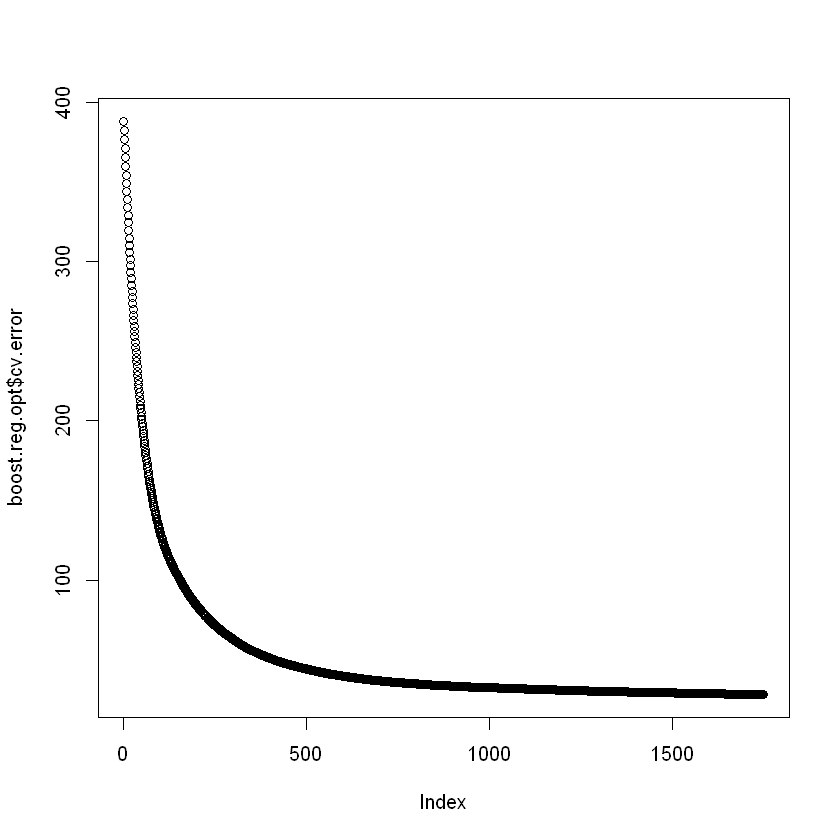

In [61]:
boost.reg.opt=gbm(Energy ~ Relative.compactness+Surface.area+Wall.area+
              Overall.height+Glazing.area+  Glazing.area.distr, data = buildRlearn,,distribution="gaussian"
              ,n.trees=1751, cv.folds=10,n.minobsinnode = 5,shrinkage=0.01,,verbose=FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg.opt$cv.error)

In [62]:
res_gbopt <- to_class_list(predict(boost.reg.opt,newdata=buildRtest))

Using 1750 trees...




In [63]:
conf_gbopt <- table(data = as.data.frame(res_gbopt), reference = buildCtest$Energy.efficiency)
conf_gbopt

    reference
data  A  B  C  D  E  F  G
   A 33  2  1  0  0  0  0
   B 10 11  4  0  0  0  0
   C  0  2  9  0  0  0  0
   D  0  1  4  4  0  0  0
   E  0  0  1 13 18  9  0
   F  0  0  0  1  4 11  9
   G  0  0  0  0  0  1  6

In [64]:
F1_Score(y_pred = as.data.frame(res_gbopt), y_true = buildCtest$Energy.efficiency)

[1] 0.835443

On constate une legere hausse du F1 score, le modele recontre des difficultées a prédire la classe B